<a href="https://colab.research.google.com/github/prasad4fun/Fast2020/blob/master/SGD_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 13.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 358kB 16.7MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 40kB 6.6MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 40kB 6.3MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 2.6MB 17.1MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

It's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [3]:
time = torch.arange(20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [4]:
(time - 9.5)**2

tensor([90.2500, 72.2500, 56.2500, 42.2500, 30.2500, 20.2500, 12.2500,  6.2500,  2.2500,  0.2500,  0.2500,  2.2500,  6.2500, 12.2500, 20.2500, 30.2500, 42.2500, 56.2500, 72.2500, 90.2500])

In [5]:
0.75 * (time - 9.5)**2 + 1 #spped reduced and picked up over time like rollercoaster

tensor([68.6875, 55.1875, 43.1875, 32.6875, 23.6875, 16.1875, 10.1875,  5.6875,  2.6875,  1.1875,  1.1875,  2.6875,  5.6875, 10.1875, 16.1875, 23.6875, 32.6875, 43.1875, 55.1875, 68.6875])

In [6]:
torch.randn(20)*3

tensor([ 5.7807,  4.4619,  2.7022, -6.3166, -2.2744,  3.2350,  2.4024,  5.0419,  1.0676, -2.0599, -1.4801,  0.7245, -0.6949,  0.1253, -0.7547,  2.5796, -0.9292, -1.1871,  2.4102, -1.8648])

In [7]:
speed = torch.randn(20)*3 + 0.75 * (time - 9.5)**2 + 1 #noise added to speed

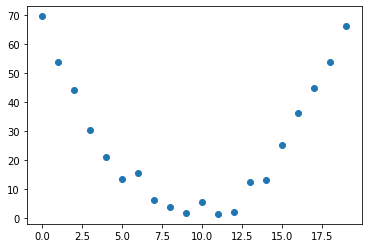

In [8]:
plt.scatter(time, speed)

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., <mark> a function of the form `a*(time**2)+(b*time)+c`.</mark>

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

In [9]:
def f(t, params): #instead of neural net lets start with simple function
  a,b,c = params
  return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best quadratic function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters a, b, and c. Thus, to find the best quadratic function, we only need to find the best values for a, b, and c.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for f first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use mean squared error:

In [10]:
def mse(preds, targets): return ((targets - preds)**2).mean()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [36]:
params = torch.randn(3).requires_grad_()

In [37]:
params

tensor([-0.7409,  0.3618,  1.9199], requires_grad=True)

In [38]:
#hide
orig_params = params.clone() #todo: understand y orig params needed

Step 2: Calculate the predictions

Next, we calculate the predictions:

In [39]:
preds = f(time, params)

In [40]:
preds

tensor([   1.9199,    1.5408,   -0.3201,   -3.6627,   -8.4873,  -14.7936,  -22.5817,  -31.8517,  -42.6034,  -54.8370,  -68.5524,  -83.7496, -100.4286, -118.5895, -138.2321, -159.3566, -181.9629,
        -206.0510, -231.6209, -258.6726], grad_fn=<AddBackward0>)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [41]:
def show_preds(preds, ax=None):
  if ax is None: ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

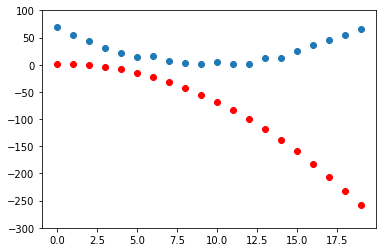

In [42]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

Step 3: Calculate the loss

In [43]:
loss = mse(preds, speed); loss

tensor(20769.5684, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

Step 4: Calculate the gradients

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [44]:
loss.backward()
params.grad

tensor([-47645.1172,  -3044.2256,   -224.3434])

In [45]:
params.grad * 1e-5

tensor([-0.4765, -0.0304, -0.0022])

We can use these gradients to improve our parameters. We'll need to pick a learning rate

In [46]:
params

tensor([-0.7409,  0.3618,  1.9199], requires_grad=True)

Step 5: Step the weights.

In [47]:
lr = 1e-5
params.data -= lr * params.grad.data 
params.grad = None

To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called required_grads_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved:

In [48]:
preds = f(time, params)
loss = mse(preds, speed)

In [49]:
loss

tensor(4414.9814, grad_fn=<MeanBackward0>)

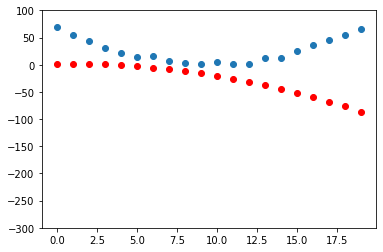

In [50]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [51]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward() #help us approximate how to tune params
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds 

Step 6: Repeat the process

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [52]:
for i in range(10): apply_step(params)

4414.9814453125
1320.190185546875
734.5579833984375
623.7350463867188
602.7609252929688
598.7886352539062
598.0335693359375
597.8872680664062
597.8565673828125
597.8472900390625


In [53]:
params

tensor([0.1024, 0.4145, 1.9253], requires_grad=True)

In [54]:
orig_params

tensor([-0.7409,  0.3618,  1.9199], grad_fn=<CloneBackward>)

In [55]:
#hide
params = orig_params.detach().requires_grad_()

In [56]:
params

tensor([-0.7409,  0.3618,  1.9199], requires_grad=True)

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

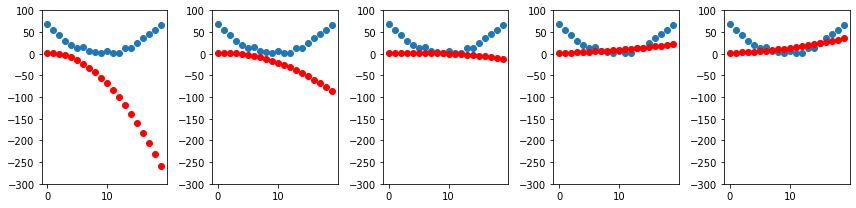

In [57]:
_,axs = plt.subplots(1, 5, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

### Summarizing Gradient Descent

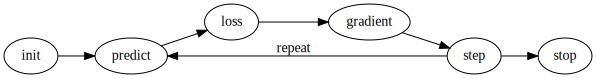

In [58]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

To summarize, at the beginning, the weights of our model can be random (training from scratch) or come from a pretrained model (transfer learning). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to learn better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a loss function, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the gradients. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the learning rate to decide on the step size. We then iterate until we have reached the lowest point, which will be our parking lot, then we can stop.